#### Подключение библиотек и скриптов

In [1]:
import pandas as pd
import numpy as np
import pickle
import random
import datetime
import os
from pathlib import Path

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import catboost as ctb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from xgboost import XGBClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})
pd.set_option('max_columns', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)
pd.set_option('max_colwidth', 300)

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    f1_test = f1_score(y_test_true, y_test_pred)
    precision_test = precision_score(y_test_true, y_test_pred)
    
    print('F1-score: ', f1_test)
    print('Precision: ', precision_test)
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('Confusion Matrix\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
    return f1_test, precision_test

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (10, len(feature_importances) * 0.5))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и построения признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета




#### Пути к директориям и файлам

In [7]:
DATASET_PATH = 'data/course_project_train.csv'
PREP_DATASET_PATH = 'data/course_project_train_prep.csv'
TEST_DATASET_PATH = 'data/course_project_test.csv'

METRICS = 'models/metrics.pkl'
MODEL_FILE_PATH = 'models/final_model.pkl'

#### Описание базового датасета
- Home Ownership - домовладение
- Annual Income - годовой доход
- Years in current job - количество лет на текущем месте работы
- Tax Liens - налоговые обременения
- Number of Open Accounts - количество открытых счетов
- Years of Credit History - количество лет кредитной истории
- Maximum Open Credit - наибольший открытый кредит
- Number of Credit Problems - количество проблем с кредитом
- Months since last delinquent - количество месяцев с последней просрочки платежа
- Bankruptcies - банкротства
- Purpose - цель кредита
- Term - срок кредита
- Current Loan Amount - текущая сумма кредита
- Current Credit Balance - текущий кредитный баланс
- Monthly Debt - ежемесячный долг
- Credit Score - баллы кредитного рейтинга
- Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Загрузка данных

In [8]:
df_base = pd.read_csv(DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

#### Выделение целевой переменной и категориальных признаков

#### Целевая переменная

In [9]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [10]:
TARGET_NAME = 'Credit Default'
CAT_FEATURE_NAMES = df_base.select_dtypes(include=['object', 'category']).columns.tolist() 
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score' ]

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


#### Обзор номинативных признаков

In [12]:
df.describe(include=['object', 'bool'])

,Home Ownership,Years in current job,Purpose,Term
count,7500,7129,7500,7500
unique,4,11,15,2
top,Home Mortgage,10+ years,debt consolidation,Short Term
freq,3637,2332,5944,5556


#### Знакомство с данными

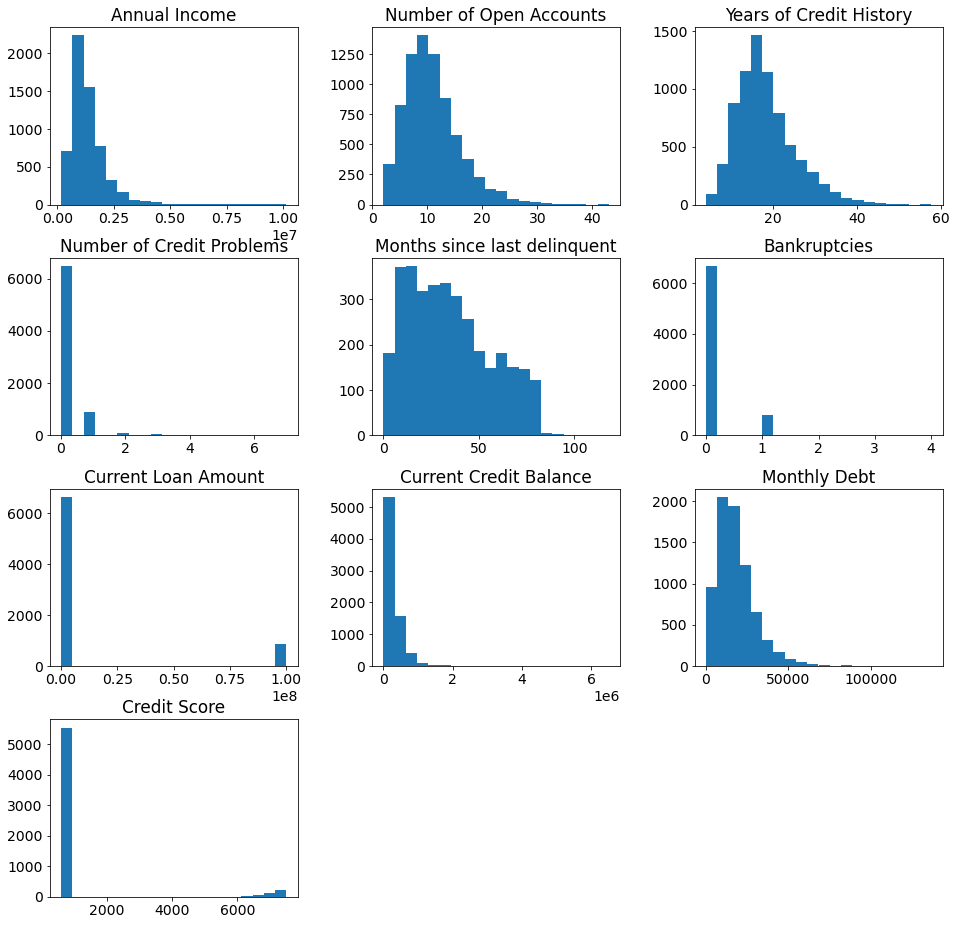

In [13]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('Tax Liens', axis=1, inplace=True)
df_num_features.drop('Maximum Open Credit', axis=1, inplace=True)
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

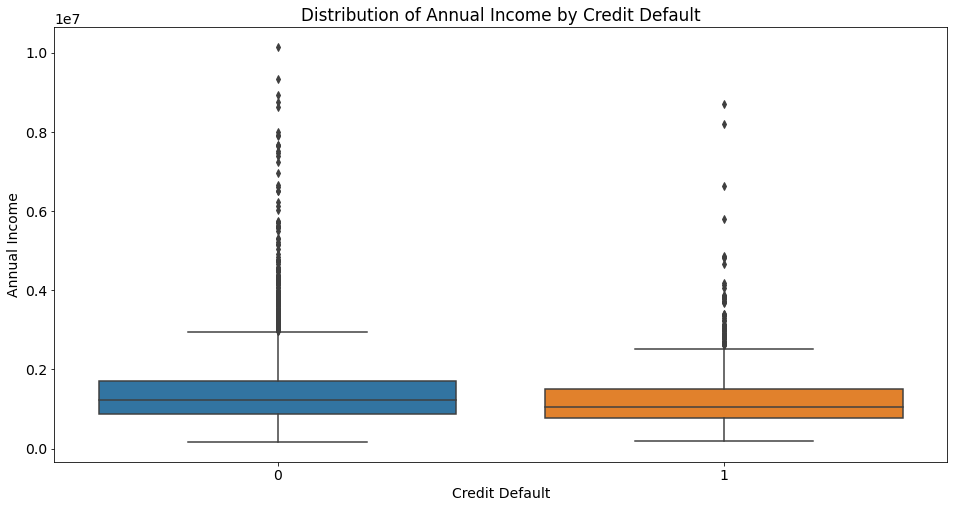

In [14]:
plt.figure(figsize=(16, 8))

sns.boxplot(df['Credit Default'], df['Annual Income'], whis=1.5)

plt.xlabel('Credit Default')
plt.ylabel('Annual Income')
plt.title('Distribution of Annual Income by Credit Default')
plt.show()

#### Обработка выбросов и пропусков

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

#### Пропуск по стажу заменим на самое популярное значение 

In [16]:
df.loc[df['Years in current job'].isna(), 'Years in current job'] = '10+ years'

#### Пропуск и один выброс по  Credit Score заменим тоже на медиану

In [17]:
df.loc[df['Credit Score'] > 1000, 'Credit Score'] = df['Credit Score'].median()
df.loc[df['Credit Score'].isna(), 'Credit Score'] = df['Credit Score'].median()

#### Убираем выброс Current Loan Amount= 99999999.0, заменой на Maximum Open Credit

In [18]:
condition = (df['Maximum Open Credit']!=0) & (df['Current Loan Amount'] == 99999999.0)
df.loc[condition, 'Current Loan Amount'] \
              = df.loc[condition,'Maximum Open Credit']

#### Убираем выброс Maximum Open Credit= 0, заменой на Current Loan Amount

In [19]:
condition = ((df['Maximum Open Credit']==0) & (df['Current Loan Amount'] != 99999999.0))
df.loc[condition, 'Maximum Open Credit'] = df.loc[condition,'Current Loan Amount']

#### Убираем остатки выбросов Current Loan Amount= 99999999.0 и 0 в Maximum Open Credit, заменой на среднее значение Current Loan Amount= 490312.220933

In [20]:
df.loc[df['Current Loan Amount'] ==99999999.0, 'Current Loan Amount'] = df['Current Loan Amount'].mean()
df.loc[df['Maximum Open Credit'] ==0, 'Maximum Open Credit'] = 490312.220933

#### Необходимо убрать пропуски по Months since last delinquent заменим  -1 

In [21]:
df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = -1

#### Уберем пропуски из признака Банкротства

In [22]:
df['Bankruptcies'] = df['Bankruptcies'].fillna(0)

#### Сделаем что-нибудь с годовым доходом

In [23]:
df['Annual Income'] = df['Annual Income'].fillna(df['Annual Income'].median())

#### Добьем выбросы по Current Loan Amount

In [24]:
amount_perc = np.percentile(df['Current Loan Amount'], 85)
df.loc[df['Current Loan Amount'] > amount_perc * 2, 'Current Loan Amount'] = None
df['Current Loan Amount'].fillna(amount_perc, inplace=True)

#### Оформим предобработку в класс

In [25]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.means=None
        
        
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        # Расчет средних значений
        self.means = X.mean()
        self.ann_median = X['Annual Income'].median()
        self.amount_perc = np.percentile(X['Current Loan Amount'], 85)
    
    def transform(self, X):
        """Трансформация данных"""
        
        

        # Years in current job
        X.loc[X['Years in current job'].isna(), 'Years in current job'] = '10+ years'
        
        
        # Credit Score
        X.loc[X['Credit Score'] > 1000, 'Credit Score'] = X['Credit Score'].median()
        X.loc[X['Credit Score'].isna(), 'Credit Score'] = X['Credit Score'].median()
        
        # Current Loan Amount
        condition = (X['Maximum Open Credit']!=0) & (X['Current Loan Amount'] == 99999999.0)
        X.loc[condition, 'Current Loan Amount'] \
              = X.loc[condition,'Maximum Open Credit']
        
        # Maximum Open Credit
        condition = ((X['Maximum Open Credit']==0) & (X['Current Loan Amount'] != 99999999.0))
        X.loc[condition, 'Maximum Open Credit'] = X.loc[condition,'Current Loan Amount']
        
        # Current Loan Amount(last)
        X.loc[X['Current Loan Amount'] ==99999999.0, 'Current Loan Amount'] = X['Current Loan Amount'].mean()
        X.loc[X['Maximum Open Credit'] ==0, 'Maximum Open Credit'] = 490312.220933
            
            
        # Months since last delinquent
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = -1
        
        # Bankruptcies
        X['Bankruptcies'] = X['Bankruptcies'].fillna(0)
        
        # Annual Income
        X['Annual Income'] = X['Annual Income'].fillna(self.ann_median)
        
        
        # Current Loan Amount
        X.loc[X['Current Loan Amount'] > self.amount_perc * 2, 'Current Loan Amount'] = None
        X['Current Loan Amount'].fillna(self.amount_perc, inplace=True)
        
        
        
        
        X['IS_PROBLEMS'] = 1
        X.loc[(X['Tax Liens'] == 0) & (X['Tax Liens'] == 0) & (X['Bankruptcies'] == 0),'IS_PROBLEMS'] = 0
       
        
        del_cols = ['Months since last delinquent']
        X.drop(columns=del_cols, inplace=True)
        
        return X

### Анализ целевой переменной

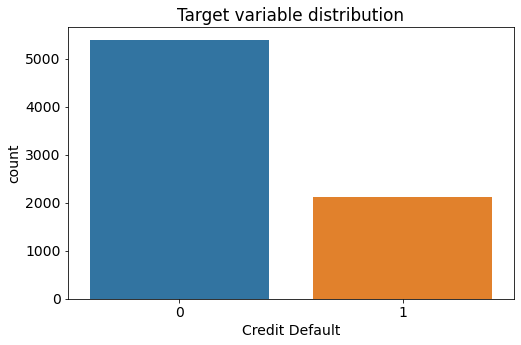

In [26]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

#### Корреляция с базовыми признаками

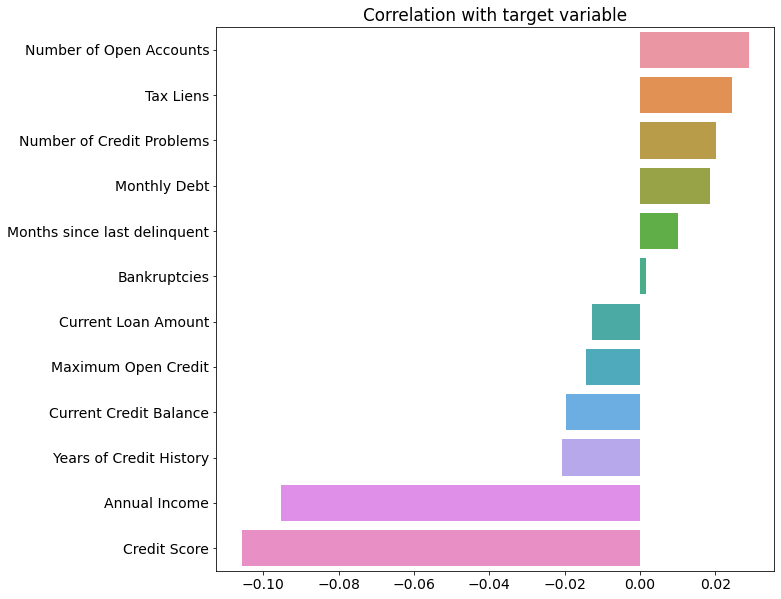

In [27]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 10))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

#### Оценка признака "Number of Credit Problems" в разрезе целевой переменной 

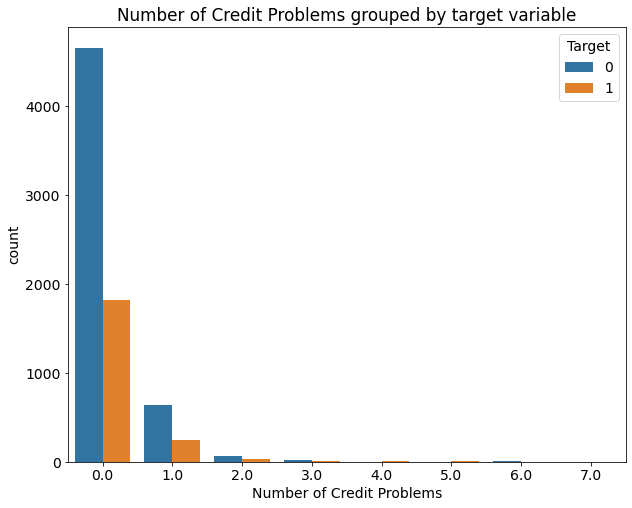

In [28]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Number of Credit Problems", hue=TARGET_NAME, data=df)
plt.title('Number of Credit Problems grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Наблюдение**

Изучив получившийся график, видно, что значения 0  и 1  признака Number of Credit Problems имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий 0 и 1 признака Number of Credit Problems в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

In [29]:
df['ID'] = df.index
Problems_and_target_s \
= df.loc[df['Number of Credit Problems'].isin([0,1]), ['ID', 'Number of Credit Problems', 'Credit Default']]

In [30]:
table = Problems_and_target_s.pivot_table(values='ID', index='Number of Credit Problems', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Number of Credit Problems,,
0.0,4654,1815
1.0,641,241


In [31]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.649296812630718

#### Оценка признака "Bankruptcies" в разрезе целевой переменной 

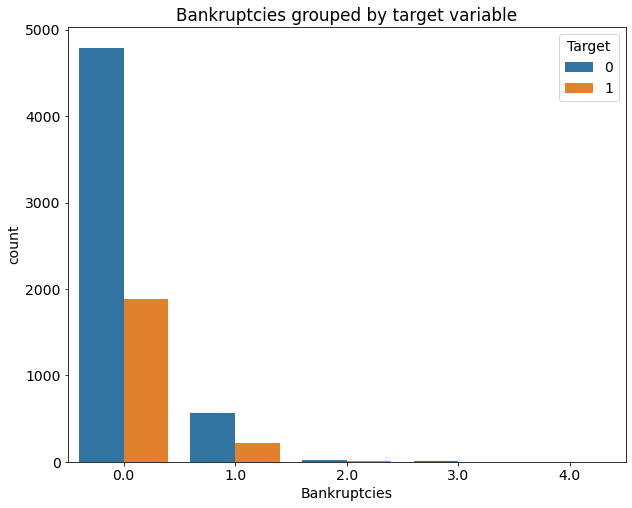

In [32]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Bankruptcies", hue=TARGET_NAME, data=df)
plt.title('Bankruptcies grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Наблюдение**

Изучив получившийся график, видно, что значения 0 и 1 признака Bankruptcies имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий 0 и 1 признака Bankruptcies в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

In [33]:
df['ID'] = df.index
Bankruptcies_and_target_s \
= df.loc[df['Bankruptcies'].isin([0, 1]), ['ID', 'Bankruptcies', 'Credit Default']]

In [34]:
table = Bankruptcies_and_target_s.pivot_table(values='ID', index='Bankruptcies', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Bankruptcies,,
0.0,4792,1882
1.0,569,217


In [35]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.7275184778309656

#### Оценка признака "Bankruptcies" в разрезе целевой переменной 

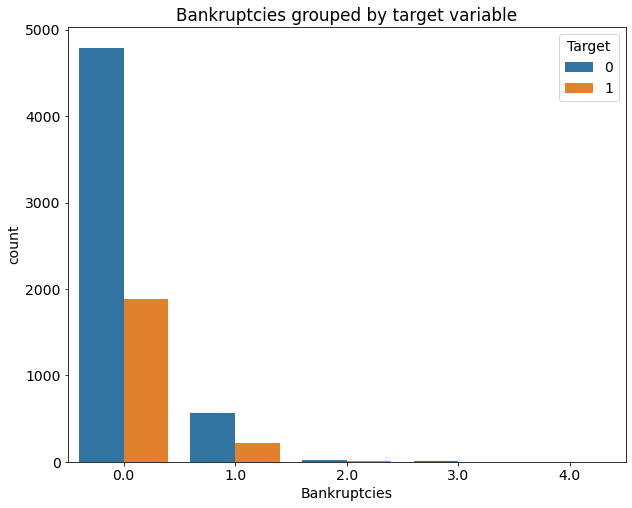

In [36]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Bankruptcies", hue=TARGET_NAME, data=df)
plt.title('Bankruptcies grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Наблюдение**

Изучив получившийся график, видно, что значения 0 и 1 признака Bankruptcies имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий 0 и 1 признака Bankruptcies в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

In [37]:
df['ID'] = df.index
Bankruptcies_and_target_s \
= df.loc[df['Bankruptcies'].isin([0, 1]), ['ID', 'Bankruptcies', 'Credit Default']]

In [38]:
table = Bankruptcies_and_target_s.pivot_table(values='ID', index='Bankruptcies', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Bankruptcies,,
0.0,4792,1882
1.0,569,217


In [39]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.7275184778309656

**Оценка признака "Credit Score" в разрезе целевой переменной**

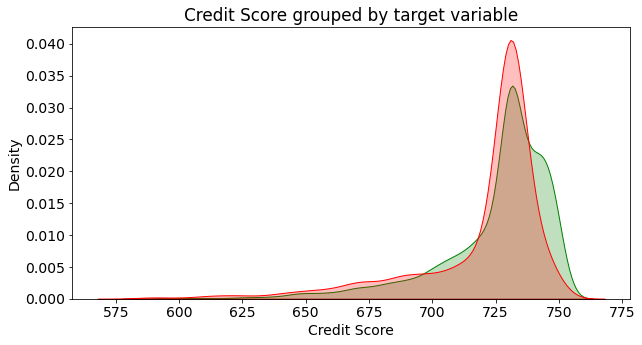

In [40]:
credit_score_with_target_s = df[['Credit Score', TARGET_NAME]]
credit_score_s = credit_score_with_target_s['Credit Score']
credit_score_target_0 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 0]
credit_score_target_1 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(credit_score_target_0, shade=True, label='No default', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака "Credit Score" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "Credit Score" и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, буде менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [41]:
shapiro(credit_score_s)

ShapiroResult(statistic=0.7849956750869751, pvalue=0.0)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график*

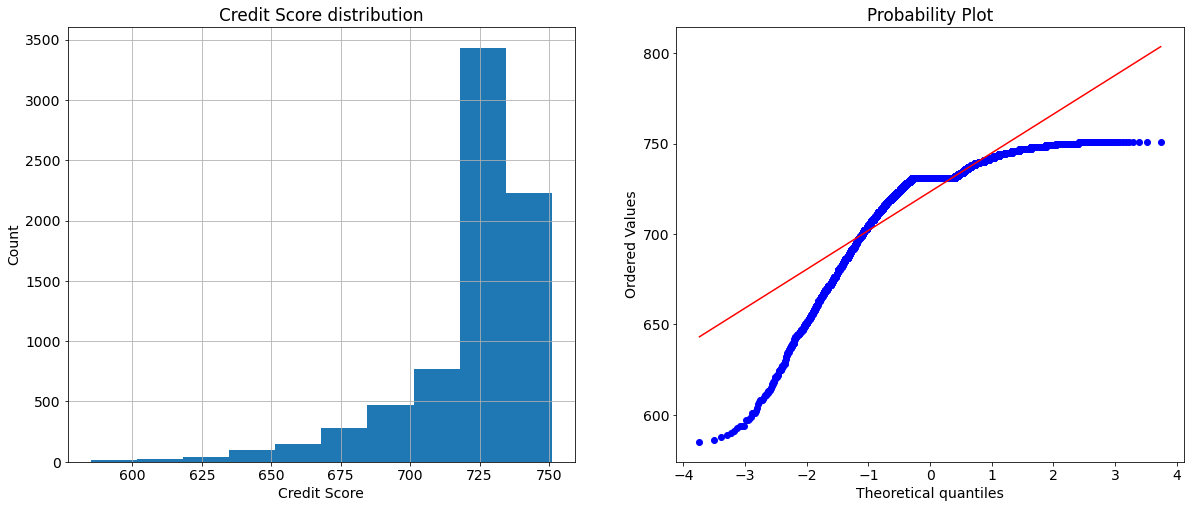

In [42]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
credit_score_s.hist()

plt.subplot(122)
probplot(credit_score_s, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака Credit Score в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

In [43]:
mannwhitneyu(credit_score_target_0, credit_score_target_1)

MannwhitneyuResult(statistic=4724307.5, pvalue=2.4689678041362667e-31)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

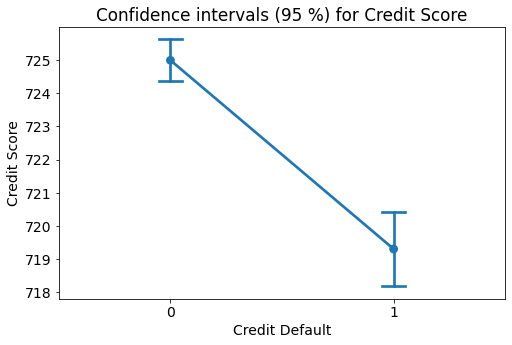

In [44]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=credit_score_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

#### Оценка признака Current Loan Amount в разрезе целевой переменной

In [45]:
loan_amount_with_target_s = df[['Current Loan Amount', TARGET_NAME]]
loan_amount_s = loan_amount_with_target_s['Current Loan Amount']
loan_amount_target_0 = loan_amount_s[loan_amount_with_target_s[TARGET_NAME] == 0]
loan_amount_target_1 = loan_amount_s[loan_amount_with_target_s[TARGET_NAME] == 1]

In [46]:
mannwhitneyu(loan_amount_target_0, loan_amount_target_1)

MannwhitneyuResult(statistic=5679249.5, pvalue=0.44289562299674373)

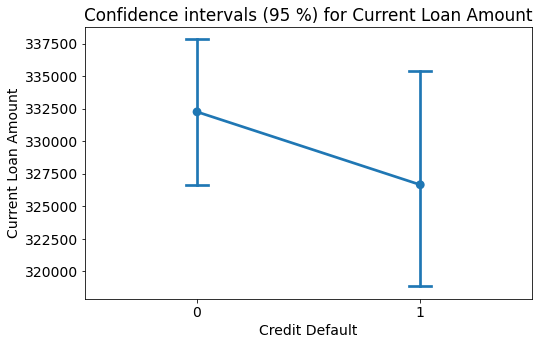

In [47]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=loan_amount_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Loan Amount')
plt.show()

#### Оценка признака Annual Income в разрезе целевой переменной

In [48]:
annual_income_with_target_s = df[['Annual Income', TARGET_NAME]]
annual_income_s = annual_income_with_target_s['Annual Income']
annual_income_target_0 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 0]
annual_income_target_1 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 1]

In [49]:
mannwhitneyu(annual_income_target_0, annual_income_target_1)

MannwhitneyuResult(statistic=4984463.5, pvalue=1.9106692844414513e-17)

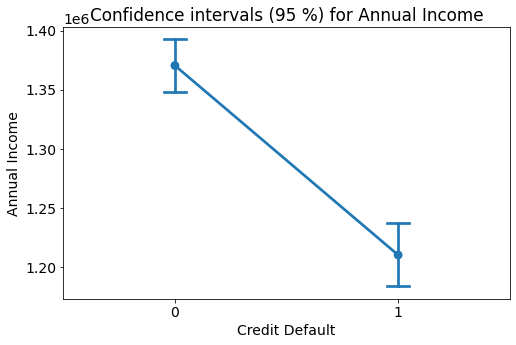

In [50]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=annual_income_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

### Анализ признакового пространства<a class="anchor" id="features_analysis"></a>

**Матрица корреляций**

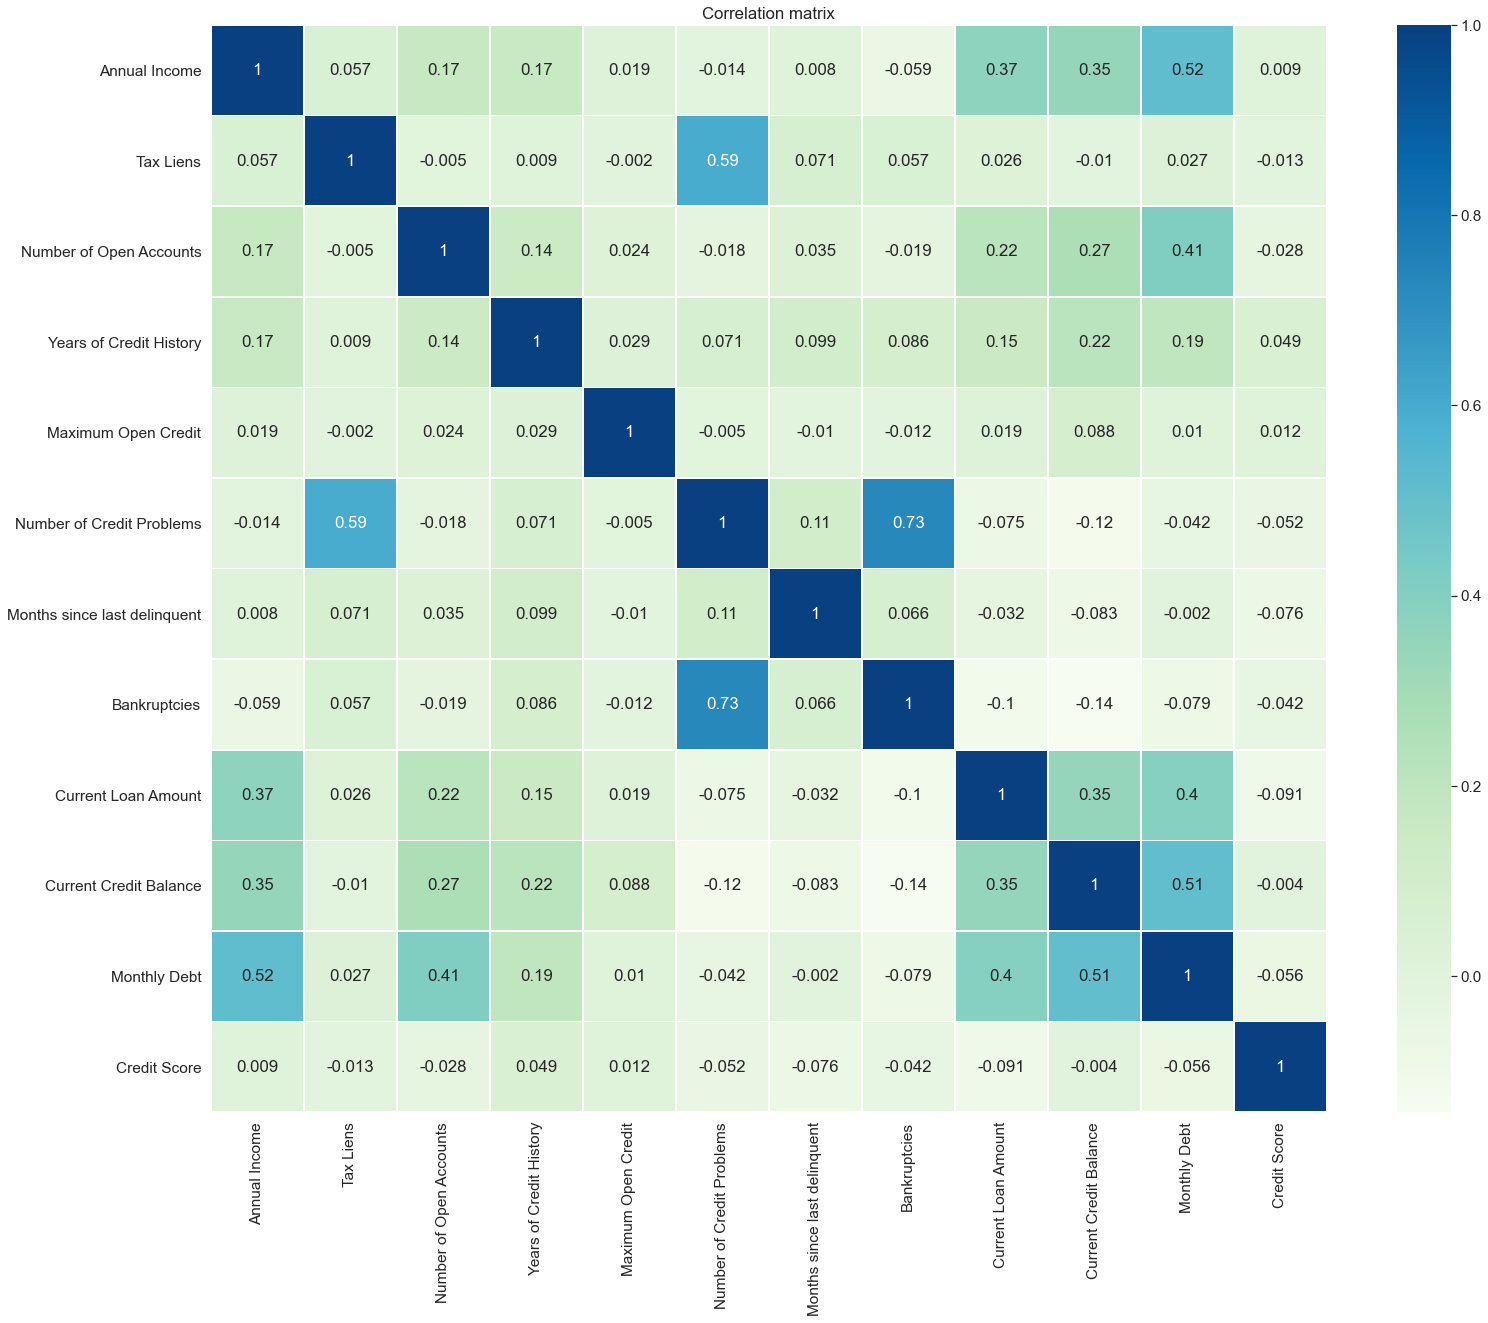

In [51]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

#### Проверим распределение вещественных признаков на трейне и тесте

In [52]:
df['Credit Default'].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

Annual Income
MannwhitneyuResult(statistic=7437874.5, pvalue=1.1638872141183186e-54)


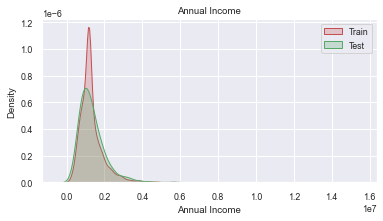

Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


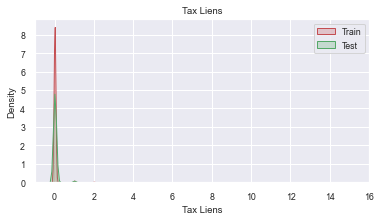

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


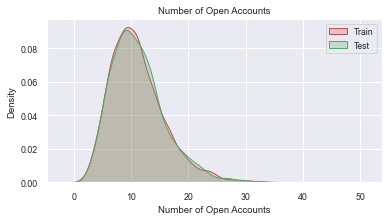

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


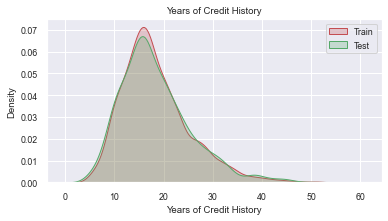

Maximum Open Credit
MannwhitneyuResult(statistic=9369590.5, pvalue=0.4827432177345362)


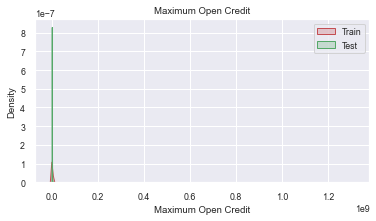

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


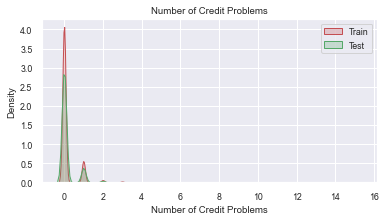

Months since last delinquent
MannwhitneyuResult(statistic=1985698.5, pvalue=0.0)


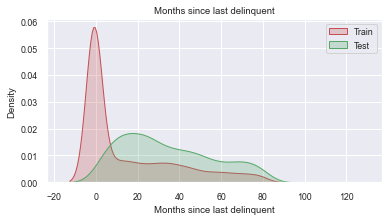

Bankruptcies
MannwhitneyuResult(statistic=9273462.0, pvalue=0.06499363911022255)


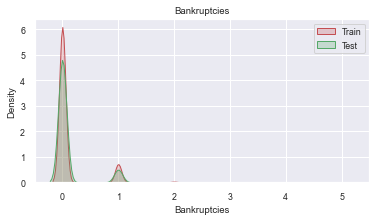

Current Loan Amount
MannwhitneyuResult(statistic=8576359.0, pvalue=8.354332463356048e-11)


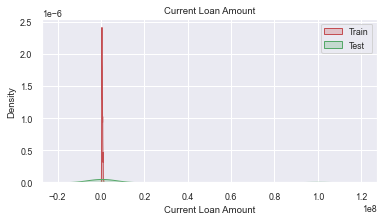

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


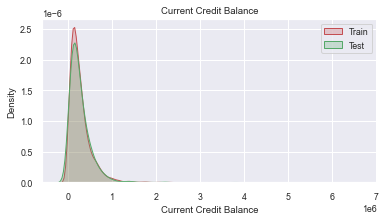

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


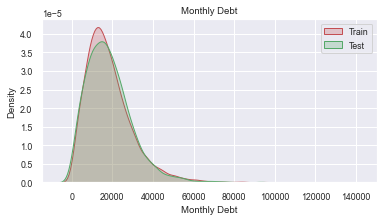

Credit Score
MannwhitneyuResult(statistic=7086848.0, pvalue=8.037145035674291e-76)


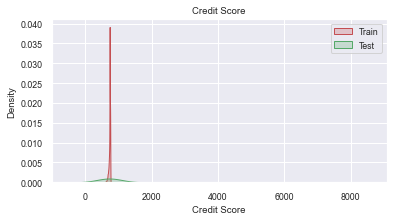

In [53]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df[col], shade=True, label='Train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='Test', color='g')
    print(col)
    print(mannwhitneyu(df[col], df_test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

#### Проверим распределения категориальных признков на трейне и тесте

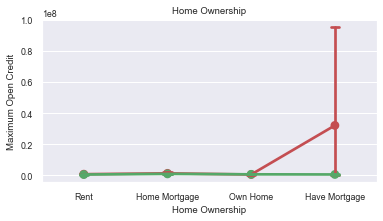

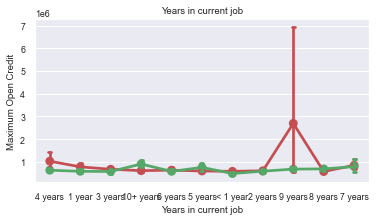

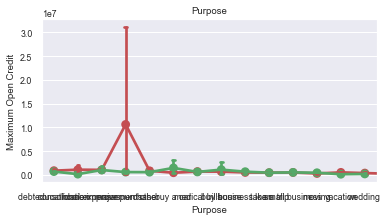

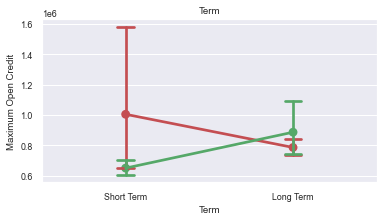

In [54]:
num_feature = 'Maximum Open Credit'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df, capsize=.1, label='Train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='Test', color='g')
    plt.title(col)
    plt.show()

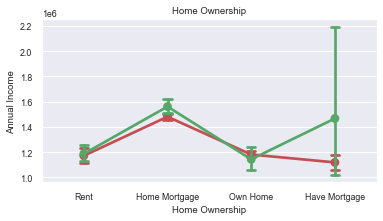

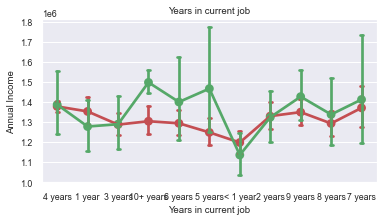

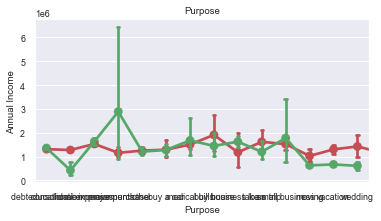

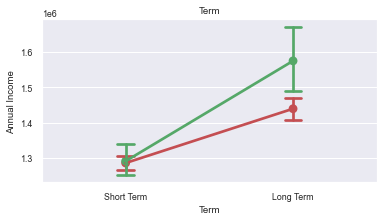

In [55]:
num_feature = 'Annual Income'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df, capsize=.1, label='Train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='Test', color='g')
    plt.title(col)
    plt.show()

#### Сократим кол-во значений в признаке 

In [56]:
df['Number of Credit Problems'].unique()

array([1., 0., 3., 2., 6., 4., 5., 7.])

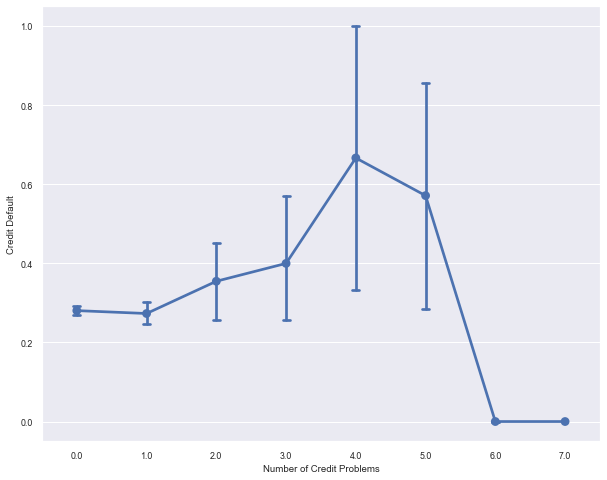

In [57]:
plt.figure(figsize=(10,8))
sns.pointplot(x='Number of Credit Problems', y='Credit Default', data=df, capsize=.1,);

In [58]:
def change_number_problem(df_ch):
    df_ch.loc[df_ch['Number of Credit Problems'].isin([0,1]), 'Number of Credit Problems'] = 0
    return df_ch

df = change_number_problem(df)

In [59]:
df['Number of Credit Problems'].value_counts()

0.0    7351
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [60]:
df['Bankruptcies'].unique()

array([1., 0., 3., 2., 4.])

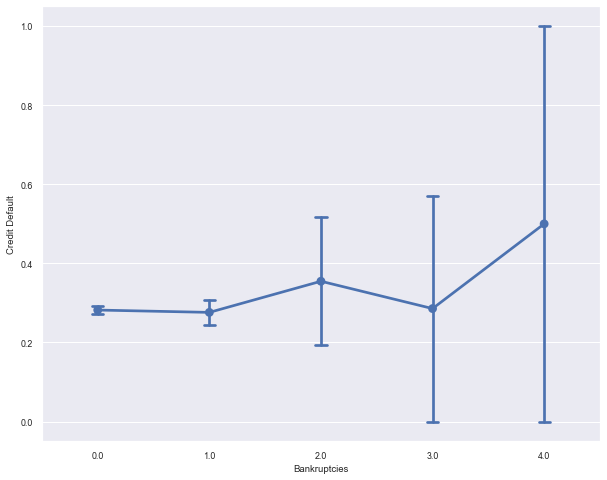

In [61]:
plt.figure(figsize=(10,8))
sns.pointplot(x='Bankruptcies', y='Credit Default', data=df, capsize=.1,);

In [62]:
def change_bankruptcies(df_ch):
    df_ch.loc[df_ch['Bankruptcies'].isin([0,1]), 'Bankruptcies'] = 0
    return df_ch

df = change_bankruptcies(df)

In [63]:
df['Bankruptcies'].value_counts()

0.0    7460
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

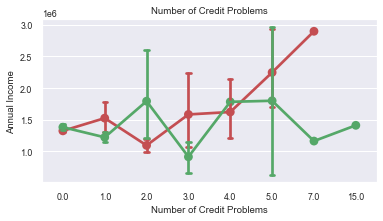

In [64]:
num_feature = 'Annual Income'
col = 'Number of Credit Problems'
plt.figure(figsize=figsize)
sns.pointplot(x=col, y=num_feature, data=df, capsize=.1, label='Train', color='r')
sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='Test', color='g')
plt.title(col)
plt.show()

### Генерация новых признаков

#### Dummies

In [65]:
df['IS_LONG_TERM'] = df['Term'].map({'Long Term':'1', 'Short Term':'0'}).astype(int)

#### Сгенерим новые составные признаки:
* Home Ownership + Annual Income
* Purpose + Credit Default

In [66]:
income_ownership = df.groupby('Home Ownership', as_index=False).median()[['Home Ownership', 'Annual Income']].\
                            rename(columns={'Annual Income': 'income_encode_ownership'})
income_ownership = pd.DataFrame(income_ownership)

In [67]:
df = df.merge(income_ownership, on='Home Ownership', how='left')

In [68]:
purpose_default = df.groupby('Purpose', as_index=False).mean()[['Purpose', 'Credit Default']].\
                            rename(columns={ 'Credit Default': 'target_encode_purpose' }) 
purpose_default  = pd.DataFrame(purpose_default) 

In [69]:
df = df.merge(purpose_default, on='Purpose', how='left') 

#### Категоризируем Кредитную историю и Кредитный рейтинг

In [70]:
df_history_max = df['Years of Credit History'].max()

def history_to_cat(X):
    bins = [0, 10, 20, 30, 40, df_history_max]
    X['history_cat'] = pd.cut(X['Years of Credit History'], bins=bins, labels=False)
    
    X['history_cat'].fillna(-1, inplace=True)
    return X
df = history_to_cat(df)

In [71]:
df['Credit Score Cat'] = 0
df.loc[(df['Credit Score'] >= 580) & (df['Credit Score'] < 670), 'Credit Score Cat'] = 1
df.loc[(df['Credit Score'] >= 670) & (df['Credit Score'] < 730), 'Credit Score Cat'] = 2
df.loc[(df['Credit Score'] >= 730) & (df['Credit Score'] < 735), 'Credit Score Cat'] = 3
df.loc[(df['Credit Score'] >= 735) & (df['Credit Score'] < 755), 'Credit Score Cat'] = 4
df.loc[df['Credit Score'] >= 755, 'Credit Score Cat'] = -1

In [72]:
df.drop(columns='ID', inplace=True)

#### Оформим генератор признаков в класс

In [73]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.long_term = None
        self.income_ownership = None
        self.history_max = None
        self.purpose_default_cat = None
      
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.long_term = {'Long Term': 1, 'Short Term': 0}
        
        self.history_max = X['Years of Credit History'].max()
        
        
        # Home Ownership
        
        self.income_ownership = X.groupby('Home Ownership', as_index=False).median()\
                                            [['Home Ownership', 'Annual Income']].rename\
                                             (columns={'Annual Income': 'income_encode_ownership'})
        self.income_ownership = pd.DataFrame(self.income_ownership) 
      
    
        self.purpose_default_cat = X.groupby('Purpose', as_index=False).mean()\
                                            [['Purpose', 'Credit Default']].rename\
                                             (columns={'Credit Default': 'target_encode_purpose'})
        self.purpose_default_cat = pd.DataFrame(self.purpose_default_cat) 
        
            
        
    def transform(self, X):
        
        # Binary features
        X['IS_LONG_TERM'] = X['Term'].map(self.long_term).astype(int)
    
        # Reduce 
        X.loc[X['Number of Credit Problems'].isin([0,1]), 'Number of Credit Problems'] = 0
        X.loc[X['Bankruptcies'].isin([0,1]), 'Bankruptcies'] = 0
        
        # More categorical features   
        
        X = self.history_to_cat(X)
        
        X['Credit Score Cat'] = 0
        X.loc[(X['Credit Score'] >= 580) & (X['Credit Score'] < 670), 'Credit Score Cat'] = 1
        X.loc[(X['Credit Score'] >= 670) & (X['Credit Score'] < 730), 'Credit Score Cat'] = 2
        X.loc[(X['Credit Score'] >= 730) & (X['Credit Score'] < 735), 'Credit Score Cat'] = 3
        X.loc[(X['Credit Score'] >= 735) & (X['Credit Score'] < 755), 'Credit Score Cat'] = 4
        X.loc[X['Credit Score'] >= 755, 'Credit Score Cat'] = -1
        
        
        if self.income_ownership is not None:
            X = X.merge(self.income_ownership, on='Home Ownership', how='left')


        # Target encoding

        if self.purpose_default_cat is not None:
            X = X.merge(self.purpose_default_cat, on='Purpose', how='left')       
        
        return X 


    def history_to_cat(self,X):
        bins = [0, 10, 20, 30, 40, self.history_max]
        X['history_cat'] = pd.cut(X['Years of Credit History'], bins=bins, labels=False)
    
        X['history_cat'].fillna(-1, inplace=True)
        return X

In [74]:
df_base = pd.read_csv(DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

#### Проведем обработку данных 

In [75]:
preprocessor = DataPreprocessing()
preprocessor.fit(df)
df = preprocessor.transform(df)
df_test = preprocessor.transform(df_test)

In [76]:
features_gen = FeatureGenerator()
features_gen.fit(df)
df = features_gen.transform(df)
df_test = features_gen.transform(df_test)

### Разбиение на train и test
(возьмем побольше данных)

In [77]:
X = df.drop(TARGET_NAME, axis=1)
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.15,
                                                    random_state=42,
                                                    stratify=y)

X_train.shape, df_test.shape

((6375, 21), (2500, 21))

In [78]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.549554565701559

### Выбор и обучение модели
(пробовал и XGBoost(даже поработал с обработкой категориальных признаков), но остановился на CatBoostCl-меньше трудозатрат на подготовку данных и важные категориальные признаки влияют на обучение в чистом виде)

In [79]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=150,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, 2.26],
                                     reg_lambda=3.11,
                                     learning_rate=0.037,
                                     n_estimators= 915
                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

F1-score:  0.5030487804878049
Precision:  0.48672566371681414
TRAIN

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      4579
           1       0.65      0.74      0.69      1796

    accuracy                           0.82      6375
   macro avg       0.77      0.79      0.78      6375
weighted avg       0.82      0.82      0.82      6375

TEST

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       808
           1       0.49      0.52      0.50       317

    accuracy                           0.71      1125
   macro avg       0.65      0.65      0.65      1125
weighted avg       0.72      0.71      0.71      1125

Confusion Matrix

col_0             0    1
Credit Default          
0               634  174
1               152  165


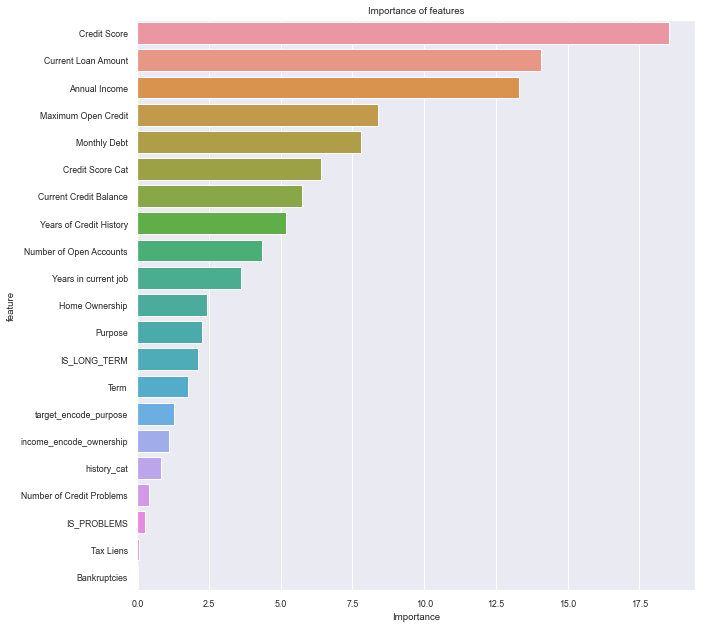

In [80]:
important_features_top = show_feature_importances(X.columns, model_catb.feature_importances_, get_top=21)

**Обучение и оценка финальной модели**

In [81]:
%%time

final_model = catb.CatBoostClassifier(silent=True, random_state=150,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, 2.26],
                                     reg_lambda=3.11,
                                     learning_rate=0.037,
                                     n_estimators= 915)

final_model.fit(X_train, y_train)

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

F1-score:  0.5222929936305732
Precision:  0.5273311897106109
TRAIN

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      4579
           1       0.77      0.84      0.80      1796

    accuracy                           0.88      6375
   macro avg       0.85      0.87      0.86      6375
weighted avg       0.89      0.88      0.88      6375

TEST

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       808
           1       0.53      0.52      0.52       317

    accuracy                           0.73      1125
   macro avg       0.67      0.67      0.67      1125
weighted avg       0.73      0.73      0.73      1125

Confusion Matrix

col_0             0    1
Credit Default          
0               661  147
1               153  164
CPU times: user 23.1 s, sys: 1.95 s, total: 25.1 s
Wall time: 9.14 s


#### Делаем предсказание на тестовой выборке


In [82]:
model = ctb.CatBoostClassifier(silent=True, random_state=150,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, 2.26],
                                     reg_lambda=3.11,
                                     learning_rate=0.037,
                                     n_estimators= 915)

model.fit(X, y)

#### Записываем результаты


In [83]:
test_predictions = model.predict(df_test)

submit = pd.read_csv('sample_submission.csv')
submit['Credit Default'] = test_predictions
submit.to_csv('sample_submission.csv', index=False)
submit.head()

,Id,Credit Default
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0


In [84]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(model, file)

In [85]:
from catboost import Pool, cv
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve
from catboost.utils import select_threshold

pool1 = Pool(data=X_train, label=y_train, cat_features=CAT_FEATURE_NAMES)
eval_pool = Pool(X_test, y_test, cat_features=CAT_FEATURE_NAMES)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = metrics.auc(fpr, tpr)

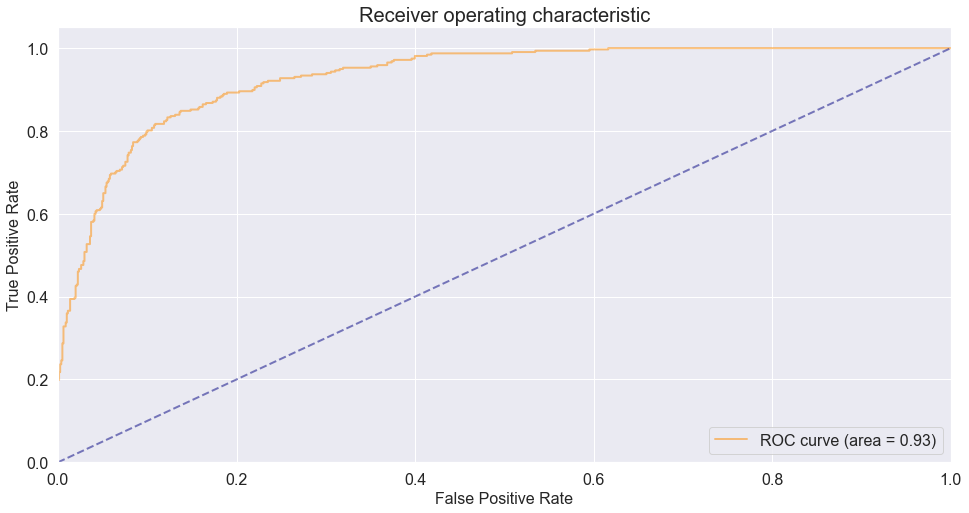

In [86]:
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)

### Выводы:
Удалось построить относительно сбалансированную модель. Балансировка не постребовалась так как есть возможность установить веса в классификаторе, вручную(автоматический подбор выдавал результат немного хуже). Избавиться от переобучения удалось увеличив кол-во данных и немного "подкрутив" лямбду.  